<a href="https://colab.research.google.com/github/renan-peres/mfin-portfolio-management/blob/main/01_portfolio_construction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Short-Term Equity Portfolio -- ***30% of Complete Portfolio***
The goal is to select the top 10 most popular stocks on news and selecting a strategy ***(based on sentiment analysis and technical indicators)*** while adhering to these following constraints:

### Step 1: Import Libraries

In [1]:
# UDFs
from py.utils import load_and_filter_data, suppress_output

# System libraries
import glob
import os
import sys
from io import StringIO
from typing import Dict, List

# Data manipulation libraries
import polars as pl
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay

# Visualization libraries
import matplotlib.pyplot as plt
from IPython.display import Image, display

# Backtesting library
import bt

In [2]:
import logging
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

# Suppress yfinance progress bars
os.environ['YFINANCE_PROGRESS'] = 'False'

# Create logger instance
logger = logging.getLogger(__name__)

logging.getLogger('bt').disabled = True
logging.getLogger('yfinance').disabled = True

# Alternative: Set logging level to critical
logging.getLogger('bt').setLevel(logging.CRITICAL)
logging.getLogger('yfinance').setLevel(logging.CRITICAL)

### Step 2: Define Parameters

#### Date Range

In [3]:
# Define the date range
end_date = (datetime.today() - BDay(1)).to_pydatetime()  # Subtract 1 business day
start_date = end_date - timedelta(days=1*365)            # 1 year before the end date

# Convert datetime objects to Unix timestamps (seconds since Jan 1, 1970)
start_timestamp = int(start_date.timestamp())
end_timestamp = int(end_date.timestamp())

# Print the date range
days_difference = (end_date - start_date).days
print(f"Date Range: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
print(f"Time span: {days_difference} days ({days_difference/365:.2f} years)")

Date Range: 2024-05-30 to 2025-05-30
Time span: 365 days (1.00 years)


#### Risk-free rate (T-bill, %)

In [4]:
daily_risk_free_df = load_and_filter_data('data/daily_treasury_rates.csv', ['^IRX'], start_date, end_date)
# risk_free_rate = .0433
risk_free_rate = daily_risk_free_df.iloc[-1, 0] / 100
print("Risk-Free Rate:", risk_free_rate, "-- 13 WEEK TREASURY BILL (^IRX)")

Found 1 of 1 tickers in data/daily_treasury_rates.csv
Missing tickers: []
Risk-Free Rate: 0.042249999999999996 -- 13 WEEK TREASURY BILL (^IRX)


#### Portfolio File

In [5]:
# Get the most recent portfolio file
portfolio_files = glob.glob('portfolios/portfolio-*.xlsx')
if portfolio_files:
    # Sort files by modification time (most recent first)
    output_file = max(portfolio_files, key=os.path.getmtime)
    print(f"Using most recent portfolio file: {output_file}")
else:
    # Fallback to current date if no files found
    output_file = f'portfolios/portfolio-{datetime.date(end_date)}.xlsx'
    print(f"No portfolio files found. Using: {output_file}")

Using most recent portfolio file: portfolios/portfolio-2025-05-30.xlsx


### Step 3: Import News Data (FMP API)
- API Documentation: https://site.financialmodelingprep.com/developer/docs/stable/stock-news

In [6]:
from py.fetch_fmp_api import create_session, fetch_data
from dotenv import load_dotenv
load_dotenv()

# Get API key from environment variables
FMP_API_KEY = os.getenv('FMP_API_KEY')
if not FMP_API_KEY:
    raise ValueError("FMP_API_KEY not found in environment variables")

# Configuration variables for fetch_data function
DAYS_BACK = 7                    # Number of days to look back for news
MAX_PAGES = 10                   # Maximum number of pages to fetch
RECORDS_PER_PAGE = 1000          # Number of records per page
REQUEST_TIMEOUT = 10             # Timeout for API requests in seconds
API_BASE_URL = "https://financialmodelingprep.com/api/v3/stock_news"
DATE_FORMAT = "%Y-%m-%d %H:%M:%S"  # Date format for parsing publishedDate

# Create session and fetch data with all required parameters
session = create_session()
data = fetch_data(
    api_key=FMP_API_KEY,
    session=session,
    days_back=30,           # Custom: 30 days back
    max_pages=15,           # Custom: 15 pages
    records_per_page=1000,  
    request_timeout=10      
)

news_df = pl.DataFrame(data)
display(news_df.sort('publishedDate', descending=True).head(10))

Fetching page 1/15...
Page 1: 1000 articles fetched
Fetching page 2/15...
Page 2: 1000 articles fetched
Fetching page 3/15...
Page 3: 1000 articles fetched
Fetching page 4/15...
Page 4: 999 articles fetched
Fetching page 5/15...
Page 5: 998 articles fetched
Fetching page 6/15...
Page 6: 998 articles fetched
Fetching page 7/15...
Page 7: 1000 articles fetched
Fetching page 8/15...
Page 8: 1000 articles fetched
Fetching page 9/15...
Page 9: 1000 articles fetched
Fetching page 10/15...
Page 10: 1000 articles fetched
Fetching page 11/15...
Page 11: 998 articles fetched
Fetching page 12/15...
Page 12: 999 articles fetched
Fetching page 13/15...
Page 13: 1000 articles fetched
Fetching page 14/15...
Page 14: 1000 articles fetched
Fetching page 15/15...
Page 15: 999 articles fetched
Total articles fetched: 14991


symbol,publishedDate,title,image,site,text,url
str,str,str,str,str,str,str
"""AMSF""","""2025-06-01 10:00:04""","""These 5 Special Dividends Are …","""https://images.financialmodeli…","""forbes.com""","""Most mainstream financial webs…","""https://www.forbes.com/sites/b…"
"""BBAI""","""2025-06-01 10:00:00""","""Pomerantz Law Firm Announces t…","""https://images.financialmodeli…","""prnewswire.com""","""NEW YORK , June 1, 2025 /PRNew…","""https://www.prnewswire.com/new…"
"""ARNC""","""2025-06-01 10:00:00""","""Bronstein, Gewirtz & Grossman,…","""https://images.financialmodeli…","""accessnewswire.com""","""NEW YORK, NY / ACCESS Newswire…","""https://www.accessnewswire.com…"
"""META""","""2025-06-01 10:00:00""","""Bronstein, Gewirtz & Grossman,…","""https://images.financialmodeli…","""accessnewswire.com""","""NEW YORK CITY, NY / ACCESS New…","""https://www.accessnewswire.com…"
"""BHVN""","""2025-06-01 10:00:00""","""INVESTOR ALERT: Pomerantz Law …","""https://images.financialmodeli…","""prnewswire.com""","""NEW YORK , June 1, 2025 /PRNew…","""https://www.prnewswire.com/new…"
"""INOD""","""2025-06-01 10:00:00""","""Bronstein, Gewirtz & Grossman,…","""https://images.financialmodeli…","""accessnewswire.com""","""NEW YORK CITY, NY / ACCESS New…","""https://www.accessnewswire.com…"
"""GO""","""2025-06-01 10:00:00""","""Bronstein, Gewirtz & Grossman,…","""https://images.financialmodeli…","""accessnewswire.com""","""NEW YORK, NY / ACCESS Newswire…","""https://www.accessnewswire.com…"
"""META""","""2025-06-01 10:00:00""","""INVESTOR ALERT: Pomerantz Law …","""https://images.financialmodeli…","""prnewswire.com""","""NEW YORK , June 1, 2025 /PRNew…","""https://www.prnewswire.com/new…"
"""VTRS""","""2025-06-01 10:00:00""","""INVESTOR ALERT: Pomerantz Law …","""https://images.financialmodeli…","""prnewswire.com""","""NEW YORK , June 1, 2025 /PRNew…","""https://www.prnewswire.com/new…"


### Step 4: Sentiment Analysis
- Use `TextBlob` for sentiment analysis on news headlines.


In [7]:
from py.sentiment_analysis import calculate_stock_sentiment_metrics, get_fundamental_value, calculate_sector_averages

# Load fundamental data and prepare ticker lists
print("Loading fundamental data...")
fundamentals_df = pl.read_csv('data/fundamentals_stock.csv')
fundamentals_pandas = fundamentals_df.to_pandas().set_index('Ticker')
all_tickers = set(news_df['symbol'].to_list() + fundamentals_df['Ticker'].to_list())
EXCLUDED_SYMBOLS = {'AI', 'S', 'A', 'U', 'E', 'US', 'ET', 'TSXV', 'CODI', 'C'}

print(f"Loaded {len(fundamentals_df)} stocks, {len(all_tickers)} unique tickers")

# Execute sentiment analysis
print("Analyzing sentiment for stock symbols...")
sentiment_metrics = calculate_stock_sentiment_metrics(news_df, all_tickers, EXCLUDED_SYMBOLS)
sentiment_df = pl.DataFrame([{
    "symbol": symbol, "articlesInLastWeek": metrics["articlesInLastWeek"],
    "companyNewsScore": metrics["companyNewsScore"], 
    "bearishPercent": metrics["sentiment"]["bearishPercent"],
    "bullishPercent": metrics["sentiment"]["bullishPercent"],
    "averageSentimentScore": metrics["averageSentimentScore"],
    "totalArticles": metrics["totalArticles"]
} for symbol, metrics in sentiment_metrics.items()]).sort(["articlesInLastWeek", "companyNewsScore"], descending=[True, True])

print(f"Sentiment analysis completed for {len(sentiment_df)} stocks")
display(sentiment_df.head(10))

# Add fundamental data and sector averages
sector_averages = calculate_sector_averages(sentiment_df, fundamentals_pandas)
sentiment_with_fundamentals = sentiment_df.with_columns([
    pl.col("symbol").map_elements(lambda x: sector_averages.get(get_fundamental_value(x, 'Sector', 'Unknown'), {}).get('sectorAverageBullishPercent', 0), return_dtype=pl.Float64).alias("sectorAverageBullishPercent"),
    pl.col("symbol").map_elements(lambda x: sector_averages.get(get_fundamental_value(x, 'Sector', 'Unknown'), {}).get('sectorAverageNewsScore', 0), return_dtype=pl.Float64).alias("sectorAverageNewsScore"),
    pl.col("symbol").map_elements(lambda x: get_fundamental_value(x, 'Sector', 'Unknown'), return_dtype=pl.Utf8).alias("sector"),
    pl.col("symbol").map_elements(lambda x: get_fundamental_value(x, 'Market Cap'), return_dtype=pl.Float64).alias("marketCap"),
    pl.col("symbol").map_elements(lambda x: get_fundamental_value(x, 'P/E (trailing)'), return_dtype=pl.Float64).alias("peRatio"),
    pl.col("symbol").map_elements(lambda x: get_fundamental_value(x, 'Price'), return_dtype=pl.Float64).alias("price")
])

# Screen stocks and analyze sectors
comprehensive_screened = sentiment_with_fundamentals.filter((pl.col("articlesInLastWeek") >= 3) & (pl.col("companyNewsScore") >= 0.45)).sort(["companyNewsScore", "articlesInLastWeek"], descending=[True, True])
sector_summary = sentiment_with_fundamentals.filter(pl.col("sector") != "Unknown").group_by("sector").agg([
    pl.count("symbol").alias("stock_count"), pl.mean("companyNewsScore").alias("avg_news_score"),
    pl.mean("bullishPercent").alias("avg_bullish_percent"), pl.mean("articlesInLastWeek").alias("avg_articles"),
    pl.mean("marketCap").alias("avg_market_cap"), pl.mean("peRatio").alias("avg_pe_ratio")
]).sort("avg_news_score", descending=True)

print(f"\nScreened {len(comprehensive_screened)} stocks, {len(sector_averages)} sectors")
display(comprehensive_screened.head(15))
display(sector_summary)

# Export results
# sentiment_with_fundamentals.write_csv("data/combined_sentiment_fundamentals.csv")
# comprehensive_screened.write_csv("data/screened_stocks.csv")
# print("Files saved: combined_sentiment_fundamentals.csv and screened_stocks.csv")

Loading fundamental data...
Loaded 504 stocks, 4274 unique tickers
Analyzing sentiment for stock symbols...
Sentiment analysis completed for 3509 stocks


symbol,articlesInLastWeek,companyNewsScore,bearishPercent,bullishPercent,averageSentimentScore,totalArticles
str,i64,f64,f64,f64,f64,i64
"""SAN""",317,0.5376,0.0536,0.3344,0.0752,317
"""IOVA""",258,0.5542,0.0233,0.5233,0.1084,258
"""VTRS""",256,0.5597,0.0195,0.5664,0.1194,256
"""OTC""",242,0.56,0.0413,0.5537,0.12,242
"""D""",242,0.5573,0.0496,0.4959,0.1146,242
"""AM""",239,0.6441,0.0042,0.7992,0.2881,239
"""CIVI""",235,0.5635,0.017,0.6298,0.1271,235
"""NET""",227,0.5387,0.0,0.4626,0.0773,227
"""NVDA""",223,0.5471,0.0852,0.435,0.0941,223



Screened 1697 stocks, 11 sectors


symbol,articlesInLastWeek,companyNewsScore,bearishPercent,bullishPercent,averageSentimentScore,totalArticles,sectorAverageBullishPercent,sectorAverageNewsScore,sector,marketCap,peRatio,price
str,i64,f64,f64,f64,f64,i64,f64,f64,str,f64,f64,f64
"""BGM""",4,0.9,0.0,1.0,0.8,4,0.0,0.0,"""Unknown""",0.0,0.0,0.0
"""LPCN""",4,0.8,0.0,1.0,0.6,4,0.0,0.0,"""Unknown""",0.0,0.0,0.0
"""NSCIF""",3,0.7803,0.0,1.0,0.5606,3,0.0,0.0,"""Unknown""",0.0,0.0,0.0
"""BBY""",24,0.7785,0.0,1.0,0.5571,24,0.5068,0.5685,"""Consumer Cyclical""",1.3848e10,15.29,65.42
"""AGS""",3,0.775,0.0,1.0,0.55,3,0.0,0.0,"""Unknown""",0.0,0.0,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…
"""FWONK""",3,0.75,0.0,1.0,0.5,3,0.0,0.0,"""Unknown""",0.0,0.0,0.0
"""MGMNF""",4,0.748,0.0,1.0,0.496,4,0.0,0.0,"""Unknown""",0.0,0.0,0.0
"""SSRM""",3,0.7456,0.0,1.0,0.4911,3,0.0,0.0,"""Unknown""",0.0,0.0,0.0


sector,stock_count,avg_news_score,avg_bullish_percent,avg_articles,avg_market_cap,avg_pe_ratio
str,u32,f64,f64,f64,f64,f64
"""Utilities""",28,0.594054,0.602171,17.142857,4.2423e10,20.590714
"""Communication Services""",19,0.579579,0.550484,26.631579,3.9629e11,NaN
"""Healthcare""",51,0.57448,0.545518,20.470588,9.1028e10,NaN
"""Technology""",77,0.571514,0.525383,16.493506,2.1723e11,NaN
"""Consumer Cyclical""",50,0.56847,0.506776,13.26,1.1792e11,NaN
…,…,…,…,…,…,…
"""Consumer Defensive""",32,0.559441,0.492869,14.90625,1.0255e11,NaN
"""Energy""",21,0.556838,0.382505,6.095238,7.0078e10,NaN
"""Real Estate""",29,0.553983,0.422083,8.724138,3.6148e10,NaN


### Step 5: Select 10 stocks by sentiment score (bullish and bearish)
- Constrained by being part of the s&p 500 index and not already in the portfolio long-term portfolio.

In [8]:
# Load long-term portfolio and select top sentiment stocks
long_term_tickers = pl.read_excel(output_file, sheet_name='long_term_portfolio')['Ticker'].to_list()
print(f"Excluding {len(long_term_tickers)} tickers already in long-term portfolio: {long_term_tickers}")

selected_stocks = (comprehensive_screened
    .filter(pl.col("sector") != 'Unknown')
    .filter(~pl.col("symbol").is_in(long_term_tickers))
    .sort("averageSentimentScore", descending=True)
    .head(100))

screened_tickers = selected_stocks['symbol'].to_list()
print(f"\nSelected {len(screened_tickers)} stocks with highest sentiment scores")
display(selected_stocks.head(10))

# Sector distribution and summary statistics
sector_distribution = selected_stocks.group_by("sector").agg([
    pl.count("symbol").alias("stock_count"),
    pl.mean("averageSentimentScore").alias("avg_sentiment_score"),
    pl.mean("companyNewsScore").alias("avg_news_score"),
    pl.mean("bullishPercent").alias("avg_bullish_percent")
]).sort("stock_count", descending=True)

print(f"\nSector distribution:")
display(sector_distribution)

# Show summary statistics
print(f"\nSummary statistics for selected stocks:")
print(f"Average sentiment score: {selected_stocks['averageSentimentScore'].mean():.4f}")
print(f"Min sentiment score: {selected_stocks['averageSentimentScore'].min():.4f}")
print(f"Max sentiment score: {selected_stocks['averageSentimentScore'].max():.4f}")
print(f"Average company news score: {selected_stocks['companyNewsScore'].mean():.4f}")
print(f"Number of stocks: {selected_stocks['symbol'].count()}")
print(f"Number of unique sectors: {selected_stocks['sector'].n_unique()}")

Excluding 5 tickers already in long-term portfolio: ['PH', 'TMUS', 'MMC', 'GS', 'SO']

Selected 100 stocks with highest sentiment scores


symbol,articlesInLastWeek,companyNewsScore,bearishPercent,bullishPercent,averageSentimentScore,totalArticles,sectorAverageBullishPercent,sectorAverageNewsScore,sector,marketCap,peRatio,price
str,i64,f64,f64,f64,f64,i64,f64,f64,str,f64,f64,f64
"""BBY""",24,0.7785,0.0,1.0,0.5571,24,0.5068,0.5685,"""Consumer Cyclical""",1.3848e10,15.29,65.42
"""ATO""",6,0.7327,0.0,1.0,0.4653,6,0.6022,0.5941,"""Utilities""",2.4434e10,21.48,153.83
"""FI""",4,0.7242,0.0,0.75,0.4484,4,0.5254,0.5715,"""Technology""",8.8477e10,28.29,159.58
"""CHTR""",5,0.71,0.0,0.8,0.42,5,0.5505,0.5796,"""Communication Services""",5.5588e10,11.23,402.42
"""NXPI""",4,0.7,0.0,0.5,0.4,4,0.5254,0.5715,"""Technology""",4.9566e10,21.37,196.2
"""GIS""",4,0.6687,0.0,0.75,0.3375,4,0.4929,0.5594,"""Consumer Defensive""",2.9425e10,11.81,53.74
"""FIS""",6,0.6643,0.0,1.0,0.3286,6,0.5254,0.5715,"""Technology""",4.1112e10,49.84,78.25
"""DTE""",16,0.6615,0.0,0.75,0.323,16,0.6022,0.5941,"""Utilities""",2.8088e10,18.29,135.35
"""XOM""",11,0.661,0.0,0.9091,0.3221,11,0.3825,0.5568,"""Energy""",4.3898e11,13.51,101.86



Sector distribution:


sector,stock_count,avg_sentiment_score,avg_news_score,avg_bullish_percent
str,u32,f64,f64,f64
"""Technology""",21,0.25119,0.625619,0.7011
"""Industrials""",16,0.24105,0.620544,0.729044
"""Utilities""",13,0.266962,0.633485,0.712146
"""Healthcare""",12,0.216025,0.608008,0.739217
"""Consumer Cyclical""",11,0.262482,0.631227,0.679009
…,…,…,…,…
"""Financial Services""",5,0.24698,0.62348,0.79696
"""Energy""",5,0.25732,0.62864,0.71656
"""Communication Services""",5,0.28956,0.64478,0.61642



Summary statistics for selected stocks:
Average sentiment score: 0.2478
Min sentiment score: 0.1757
Max sentiment score: 0.5571
Average company news score: 0.6239
Number of stocks: 100
Number of unique sectors: 11


### Step 6: Import Stock Quotes

In [9]:
from py.utils import suppress_output

quotes = suppress_output(bt.get, screened_tickers, start=start_date, end=end_date)
display(quotes.tail(10))

,bby,ato,fi,chtr,nxpi,gis,fis,dte,xom,ir,...,intu,fe,dltr,ceg,ulta,jnj,apa,ko,dg,ew
Date,,,,,,,,,,,,,,,,,,,,,
2025-05-16,73.800003,156.807785,166.660004,427.250000,212.559998,55.130001,79.860001,138.070007,108.190002,84.010002,...,670.280029,42.680000,86.510002,291.119995,412.989990,150.043686,17.590000,72.000000,93.550003,78.000000
2025-05-19,71.599998,159.095062,169.139999,418.630005,210.360001,54.830002,80.980003,138.570007,106.470001,83.550003,...,670.859985,42.849998,86.610001,294.019989,410.089996,151.193832,17.320000,71.930000,98.180000,78.040001
2025-05-20,71.150002,158.219940,165.869995,423.489990,210.080002,54.790001,80.599998,138.389999,104.949997,82.919998,...,671.159973,42.730000,90.620003,292.399994,414.399994,152.353882,17.250000,71.690002,102.199997,77.830002
2025-05-21,70.150002,156.091782,162.220001,415.440002,205.350006,53.360001,79.169998,136.110001,103.660004,81.190002,...,659.979980,42.270000,88.919998,287.109985,404.750000,151.877960,16.709999,71.849998,100.779999,76.099998
2025-05-22,70.760002,154.431000,161.339996,409.929993,196.509995,53.340000,78.339996,134.619995,102.970001,81.199997,...,666.070007,41.990002,89.970001,291.470001,410.390015,151.312805,16.740000,71.139999,100.639999,74.790001
2025-05-23,69.919998,156.410004,159.339996,406.359985,192.149994,53.380001,78.220001,136.320007,103.029999,80.379997,...,720.130005,42.110001,88.169998,297.489990,407.040009,151.639999,16.850000,71.769997,101.389999,74.989998
2025-05-27,72.220001,156.490005,160.139999,411.130005,198.899994,54.130001,79.959999,137.119995,103.519997,82.589996,...,751.960022,42.099998,90.360001,309.059998,421.309998,153.250000,17.309999,71.779999,100.980003,76.220001
2025-05-28,71.519997,153.720001,160.740005,407.380005,196.210007,53.369999,79.970001,134.979996,102.110001,81.839996,...,754.450012,41.189999,89.339996,308.049988,417.010010,152.429993,17.180000,71.150002,97.769997,76.660004
2025-05-29,66.320000,154.339996,159.619995,395.809998,195.889999,53.990002,78.269997,136.259995,102.690002,82.150002,...,757.219971,41.700001,90.580002,303.369995,421.790009,153.580002,17.340000,71.489998,97.070000,77.730003


### Step 7: Create Trading Signals
- Use `talib` library to create signals.

In [10]:
from py.technical_analysis import calculate_technical_indicators, generate_trading_signals

# Execute technical analysis
technical_indicators = calculate_technical_indicators(quotes)
trading_signals = generate_trading_signals(technical_indicators)
available_tickers = list(technical_indicators.keys())

# Display sample results for first ticker
sample_ticker = available_tickers[0]
print(f"\nSample indicators and signals for {sample_ticker}:")
display(technical_indicators[sample_ticker].tail(5))

✅ Technical indicators calculated for 100 tickers
✅ Trading signals generated for 100 tickers

Sample indicators and signals for bby:


,Close,SMA_20,SMA_50,SMA_200,EMA_12,EMA_26,EMA_50,ADX,PLUS_DI,MINUS_DI,RSI_14,RSI_21
Date,,,,,,,,,,,,
2025-05-23,69.919998,69.8850,68.353316,82.888460,70.671606,69.689109,70.661822,13.754470,50.782719,49.217281,50.782719,49.738551
2025-05-27,72.220001,70.1220,68.385867,82.859095,70.909820,69.876582,70.722928,13.779281,57.050909,42.949091,57.050909,53.703091
2025-05-28,71.519997,70.3640,68.359390,82.817231,71.003694,69.998316,70.754185,13.475742,54.764869,45.235131,54.764869,52.382686
2025-05-29,66.320000,70.3455,68.241552,82.743705,70.283125,69.725849,70.580296,13.731621,41.470973,58.529027,41.470973,43.953380
2025-05-30,66.279999,70.3075,68.109880,82.682221,69.667260,69.470600,70.411656,13.981114,41.387744,58.612256,41.387744,43.896326


### Step 8: Backtest Strategies
- Use `bt` library for backtesting the strategy.

In [11]:
from py.technical_analysis import run_backtest, best_strategy_analysis

# Configuration constants
PORTFOLIO_CONFIG = {
    'min_cagr': 0.1,        # Minimum 10% CAGR
    'max_volatility': 0.3,  # Maximum 30% volatility
    'max_stocks': 10        # Maximum 10 stocks in portfolio
}

# Step 1: Run strategy backtesting
backtest_data = run_backtest(quotes, trading_signals, available_tickers)

# Step 2: Analyze best strategies and build portfolio
analysis_results = best_strategy_analysis(quotes, trading_signals, backtest_data, available_tickers, **PORTFOLIO_CONFIG)

STRATEGY BACKTESTING ANALYSIS

🔄 Running strategy backtests...
🔄 Running 400 backtests silently...
  Progress: 5%
  Progress: 10%
  Progress: 15%
  Progress: 20%
  Progress: 25%
  Progress: 30%
  Progress: 35%
  Progress: 40%
  Progress: 45%
  Progress: 50%
  Progress: 55%
  Progress: 60%
  Progress: 65%
  Progress: 70%
  Progress: 75%
  Progress: 80%
  Progress: 85%
  Progress: 90%
  Progress: 95%
  Progress: 100%
✅ Backtesting completed

🔄 Portfolio Construction
📊 CAGR Filtering: 100 → 57 tickers (≥10.0%)
📊 Volatility Filtering: → 39 tickers (≤30.0%)
🏆 Selected top 10 performers:
  #1. cnp: 44.60% CAGR, 19.97% Vol, Sharpe: 1.96 (EMA_Cross_Signal)
  #2. gild: 42.95% CAGR, 25.17% Vol, Sharpe: 1.55 (EMA_Cross_Signal)
  #3. nvr: 37.11% CAGR, 23.07% Vol, Sharpe: 1.49 (SMA_Cross_Signal)
  #4. pm: 36.10% CAGR, 24.98% Vol, Sharpe: 1.37 (EMA_Cross_Signal)
  #5. fis: 35.83% CAGR, 25.11% Vol, Sharpe: 1.35 (SMA_Cross_Signal)
  #6. ndaq: 32.96% CAGR, 23.42% Vol, Sharpe: 1.34 (EMA_Cross_Signal)
  

,cagr,total_return,max_drawdown,sharpe_ratio,volatility,strategy
cnp,0.445980,0.447076,-0.086500,1.958108,0.199694,EMA_Cross_Signal
gild,0.429499,0.430548,-0.178775,1.554255,0.251708,EMA_Cross_Signal
nvr,0.371052,0.371941,-0.103269,1.492007,0.230705,SMA_Cross_Signal
pm,0.361047,0.361908,-0.234092,1.367343,0.249787,EMA_Cross_Signal
fis,0.358283,0.359137,-0.119634,1.349912,0.251136,SMA_Cross_Signal
ndaq,0.329605,0.330383,-0.138756,1.340860,0.234192,EMA_Cross_Signal
anet,0.306015,0.306731,-0.096810,1.132834,0.265629,RSI_Signal
lmt,0.295949,0.296639,-0.132242,1.295686,0.219787,SMA_Cross_Signal
fcx,0.287298,0.287966,-0.058374,1.472064,0.183269,RSI_Signal
amd,0.286572,0.287238,-0.088035,1.079278,0.263510,RSI_Signal


✅ Strategy Analysis Complete!

📈 Portfolio: 10 stocks
  📊 Avg CAGR: 34.71% | Avg Sharpe: 1.40 | Avg Volatility: 23.49% | Avg Drawdown: -12.36%
  🎯 Strategy Distribution:
    - EMA_Cross_Signal: 4 stocks (40.0%)
    - SMA_Cross_Signal: 3 stocks (30.0%)
    - RSI_Signal: 3 stocks (30.0%)


### Step 9: Plot the Best Strategies

📊 Generating Portfolio Charts...

📈 Portfolio Performance:


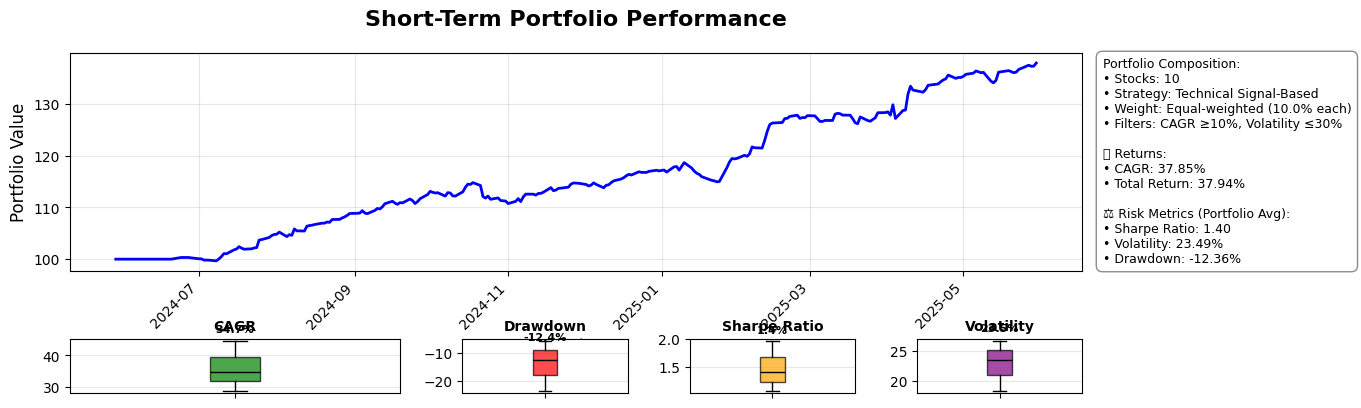


📈 Strategy Signals by Ticker:
📋 Included tickers: ['cnp', 'gild', 'nvr', 'pm', 'fis', 'ndaq', 'anet', 'lmt', 'fcx', 'amd']
📊 Plotting 10 tickers that passed the 10% CAGR and ≤30% volatility thresholds


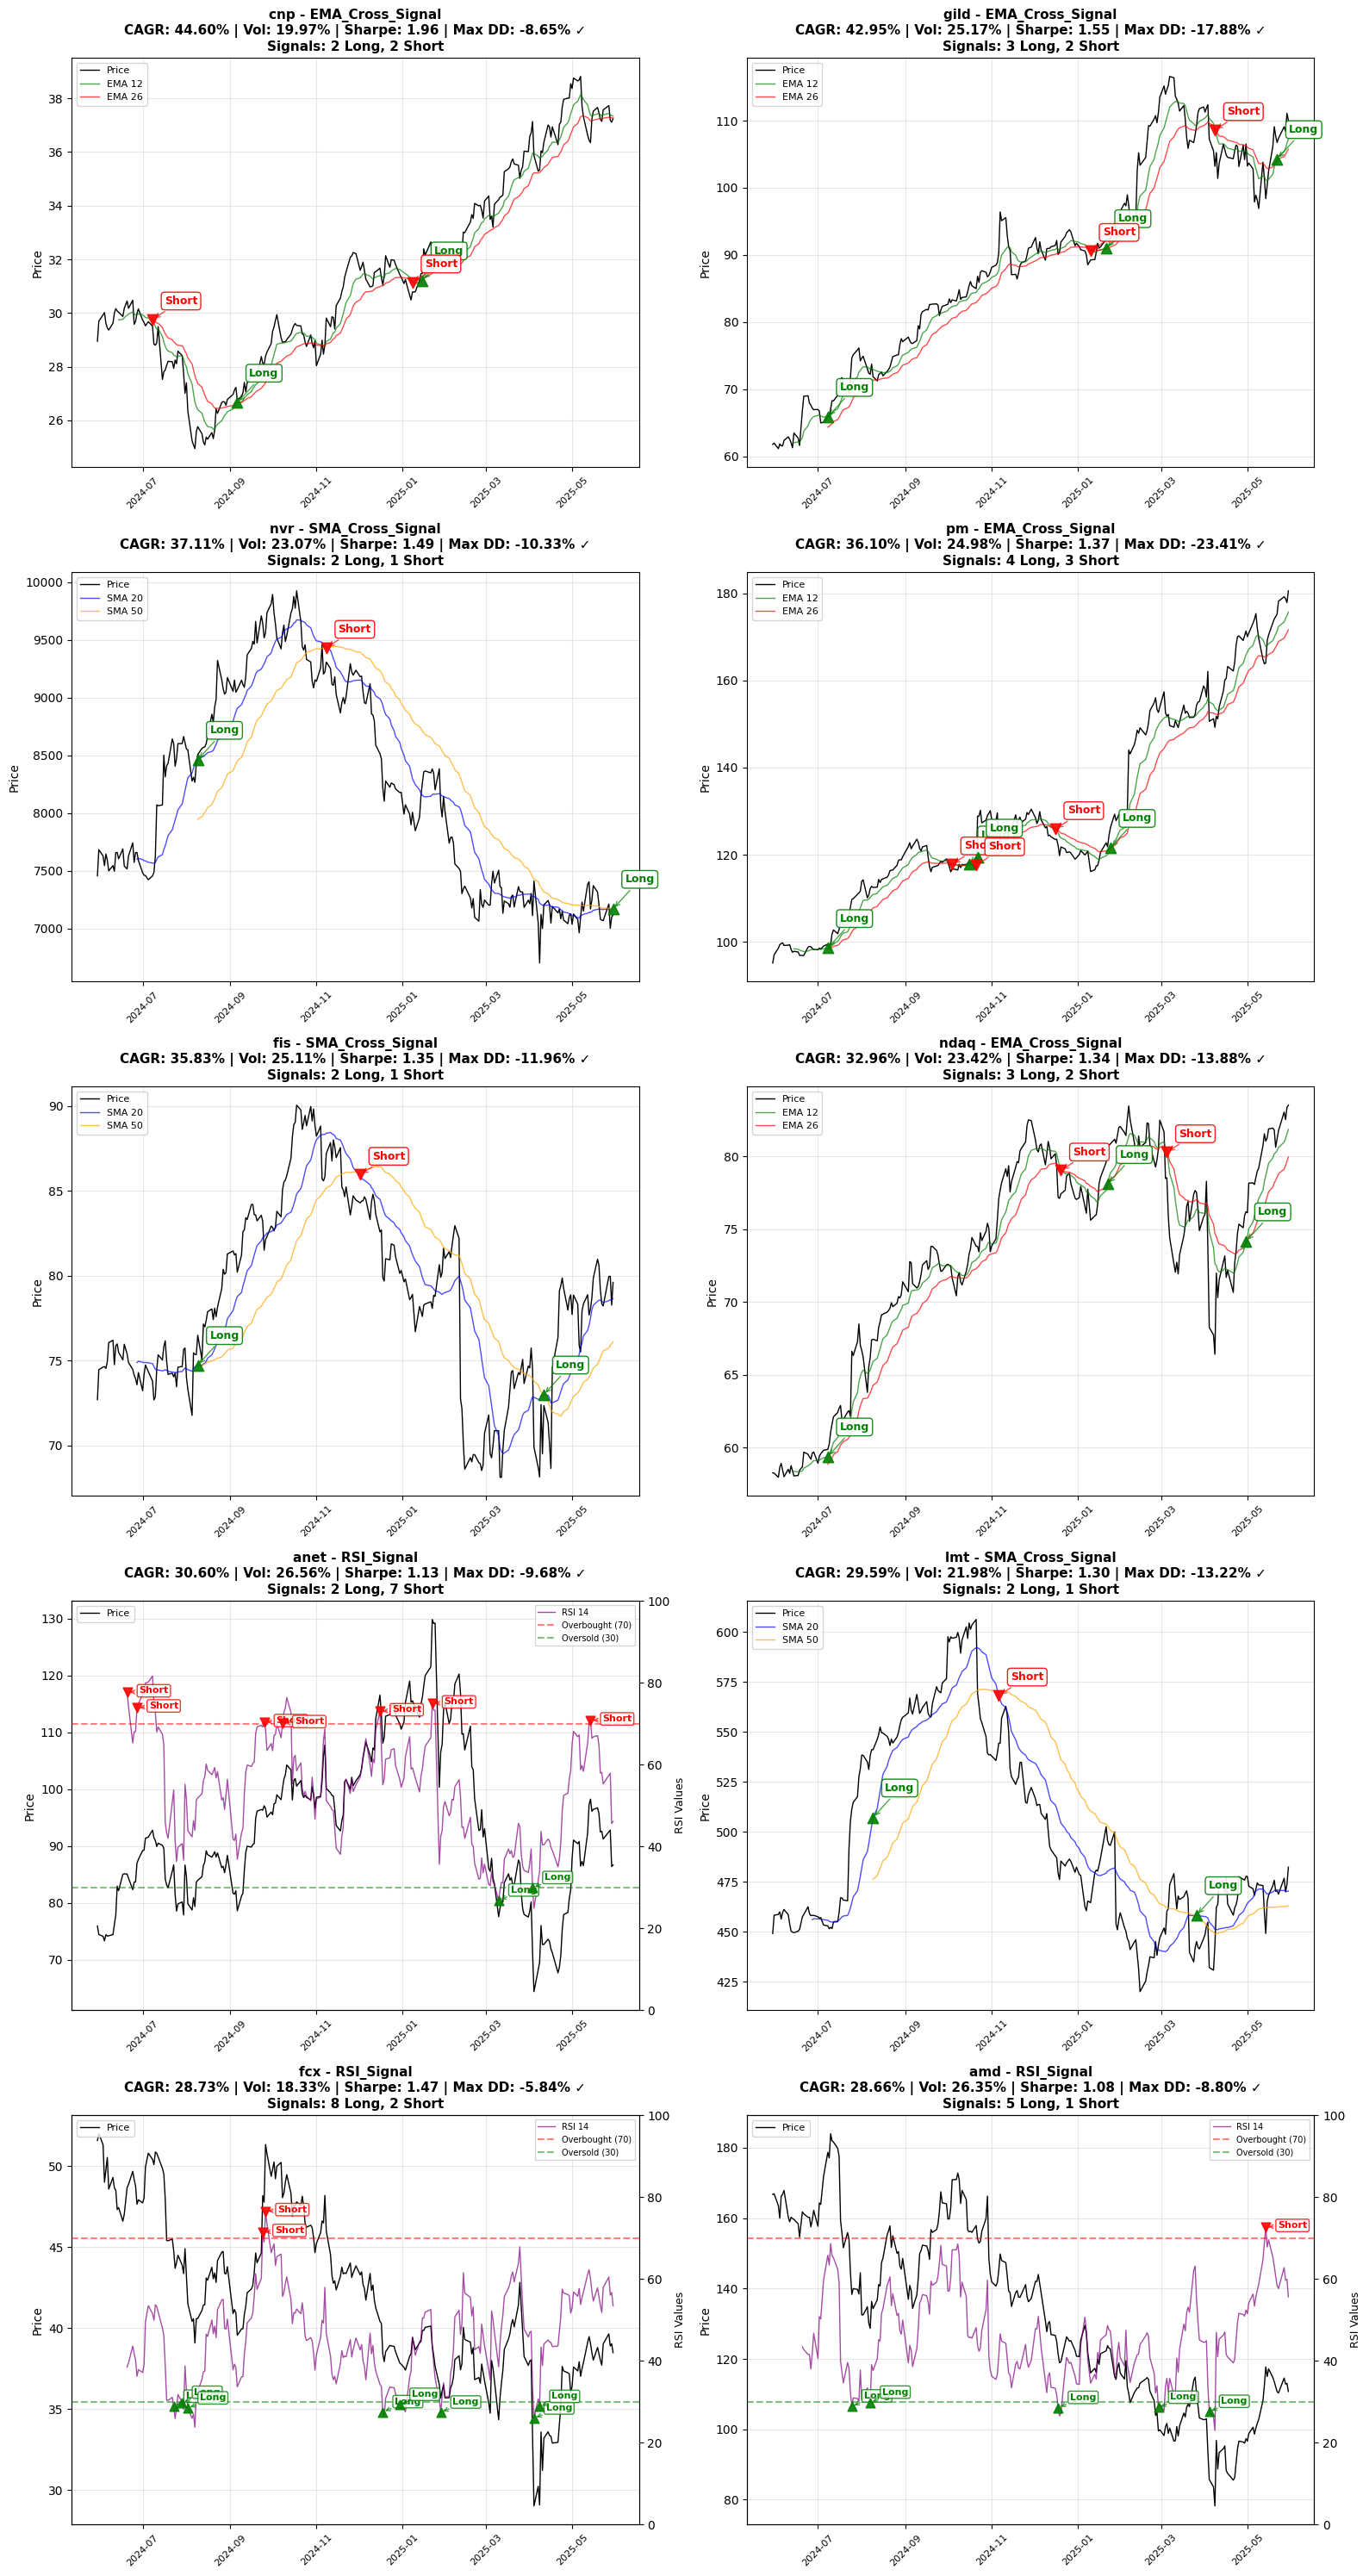


✅ Chart generation complete!


In [12]:
from py.technical_analysis import plot_portfolio_performance, plot_ticker_signals_with_annotations

# Chart generation
print("📊 Generating Portfolio Charts...")

for chart_type, func in [("Portfolio Performance", lambda: plot_portfolio_performance(analysis_results)), 
                         ("Strategy Signals by Ticker", lambda: plot_ticker_signals_with_annotations(
                             quotes, trading_signals, technical_indicators, 
                             analysis_results['best_strategies'], analysis_results['included_tickers'])
                          if all([quotes is not None, trading_signals, technical_indicators,
                                 all(key in analysis_results for key in ['best_strategies', 'included_tickers']),
                                 analysis_results['included_tickers']]) 
                          else print("⚠️ Missing required data or no tickers passed thresholds"))]:
    try:
        print(f"\n📈 {chart_type}:")
        if chart_type == "Strategy Signals by Ticker" and analysis_results.get('included_tickers'):
            print(f"📋 Included tickers: {analysis_results['included_tickers']}")
        func()
    except Exception as e:
        print(f"Error plotting {chart_type.lower()}: {e}")

print("\n✅ Chart generation complete!")

### Step 11: Plot the Portfolio Weights

In [13]:
# Calculate industry weights
industry_df = pd.DataFrame({
    'Ticker': filtered_tickers,
    'Weight': filtered_weights,
    'Sector': [fundamentals_df.loc[ticker, 'Sector'] for ticker in filtered_tickers]
})
sector_weights = industry_df.groupby('Sector')['Weight'].sum()
industries = sector_weights.index.tolist()
weights = sector_weights.values.tolist()

NameError: name 'filtered_tickers' is not defined

In [ ]:
# Plot asset allocation
plot_portfolio_weights(
    filtered_tickers, 
    filtered_weights,
    'Portfolio Weight Allocation (By Asset)', 
    'Assets',
    metrics=[
        ('Sharpe Ratio', optimal_sharpe_ratio, 4, False),
        ('Expected Return', optimal_portfolio_return, 2, True),
        ('Expected Volatility', optimal_portfolio_volatility, 2, True)
    ],
    rotation=0,
    show_constraints=True,
    max_allocation_weight=max_allocation_weight,
    max_assets=max_assets,
    max_asset_per_sector=max_asset_per_sector
)

# Plot sector allocation
plot_portfolio_weights(
    industries, 
    weights,
    'Portfolio Weight Allocation (By Sector)', 
    'Industries',
    metrics=[
        ('Sharpe Ratio', optimal_sharpe_ratio, 4, False),
        ('Expected Return', optimal_portfolio_return, 2, True),
        ('Expected Volatility', optimal_portfolio_volatility, 2, True)
    ],
    rotation=45,
    show_constraints=True,
    max_allocation_weight=max_allocation_weight,
    max_assets=max_assets,
    max_asset_per_sector=max_asset_per_sector
)

### Step 12: Export Potfolio to Excel

#### Prepare DataFrame for Export

In [ ]:
# Merge Portfolio Daily Quotes with risk-free rate
daily_prices_df_merged = daily_prices_df[filtered_tickers].join(daily_risk_free_df, how='inner')

# Create a Monthly Price DataFrame
monthly_prices_df_merged = daily_prices_df_merged.copy()

# Make sure index is datetime (redundant if already datetime, but safe)
monthly_prices_df_merged.index = pd.to_datetime(monthly_prices_df_merged.index)

# Resample to monthly (start of month) and get the last value
monthly_prices_df_merged = (monthly_prices_df_merged
                           .resample('MS').last()
                           .reset_index()
                           .rename(columns={'index': 'Date'}))

# Set Index to Date
monthly_prices_df_merged.reset_index(drop=True, inplace=True)
monthly_prices_df_merged.set_index(['Date'], inplace=True)

# Display
display(monthly_prices_df_merged.sort_index(axis=0, ascending=False).sort_index(axis=1, ascending=True))

#### Export DataFrame to Excel

In [ ]:
# Create a single Excel file with multiple sheets
with pd.ExcelWriter(output_file) as writer:
    # Each DataFrame goes to a different sheet
    optimal_portfolio_df.to_excel(writer, sheet_name='equity')

    # Export daily_quotes
    daily_prices_df_merged.to_excel(writer, sheet_name='daily_quotes')

    # Export daily_quotes
    monthly_prices_df_merged.to_excel(writer, sheet_name='monthly_quotes')

    # Export daily_quotes
    monthly_prices_df_merged.to_excel(writer, sheet_name='monthly_quotes')

    # Export risk_free
    last_risk_free_df.to_excel(writer, sheet_name='risk_free')